# Measuring the SFR From Luminosity
Notebook to measure the SFR of each galaxy from the IR and UV luminosities. Need to find the formula online, and can just directly do the calculation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

import astropy.units as u

### Importing Data

In [2]:
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/data'

In [3]:
my_cosmo_cat = pd.read_csv(f'{data_folder}/cosmos-matched-all-eazy-df.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (466) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
my_cosmo_cat.head()

,SourceID,id_1_2020,id_2_2020,ez_LIR_1,ez_L2800_1,ez_LIR_2,ez_L2800_2,ra_1,dec_1,clon_1,...,ssfr_med_2,ssfr_med_min68_2,ssfr_med_max68_2,ssfr_best_2,l_nu_2,l_r_2,l_k_2,dist_2,angle_2,category
0,4000705532455,816891,812427,1.461746e+10,6.532970e+09,4.550346e+08,3.795326e+08,150.679866,2.196563,10h02m43.17s,...,-8.625,-8.745,-8.435,-8.666,27.074,27.260,27.124,9.361438,123.114321,NaN
1,4000705533312,873195,872551,3.561132e+10,1.346792e+09,1.310930e+11,5.523424e+09,150.668120,2.242867,10h02m40.35s,...,-10.300,-10.368,-10.231,-10.258,28.661,29.620,29.874,2.627196,14.847254,stage3
2,4000705533383,861738,861742,5.621026e+09,5.348111e+09,2.269957e+10,2.636891e+09,150.645145,2.237538,10h02m34.83s,...,-8.440,-8.550,-8.334,-8.448,29.135,29.232,29.068,2.241379,287.399545,stage1
3,4000705539529,1284864,1281998,4.125722e+10,1.431745e+10,5.301575e+08,2.605845e+09,149.686238,2.637428,09h58m44.70s,...,-8.863,-8.987,-8.724,-8.830,28.323,28.572,28.466,3.301196,89.699137,stage1
4,4000705539941,1301188,1300267,5.449620e+07,3.591865e+08,1.352380e+09,3.631612e+08,149.702477,2.654904,09h58m48.59s,...,-8.270,-8.574,-8.054,-8.240,27.618,27.623,27.561,5.171943,338.551088,stage2


### Separating DataFrame

In [5]:
prims_df = (
    my_cosmo_cat[['SourceID', 'id_1', 'id_1_2020', 'ez_LIR_1', 'ez_L2800_1', 'sfr_best_1', 'photoz_1', 'mass_best_1']]
    .rename(columns = {'id_1' : 'id_2015', 'id_1_2020' : 'id_2020', 'ez_LIR_1' : 'ez_LIR', 'ez_L2800_1' : 'ez_L2800', 'sfr_best_1' : 'sfr_best', 'photoz_1' : 'photoz', 'mass_best_1' : 'mass_best'})
    .assign(gal = 'prim')
)
secs_df = (
    my_cosmo_cat[['SourceID', 'id_2', 'id_2_2020', 'ez_LIR_2', 'ez_L2800_2', 'sfr_best_2', 'photoz_2', 'mass_best_2']]
    .rename(columns = {'id_2' : 'id_2015', 'id_2_2020' : 'id_2020', 'ez_LIR_2' : 'ez_LIR', 'ez_L2800_2' : 'ez_L2800', 'sfr_best_2' : 'sfr_best', 'photoz_2' : 'photoz',  'mass_best_2' : 'mass_best'})
    .assign(gal = 'sec')
)

In [6]:
concat_df = pd.concat([prims_df, secs_df]).dropna()
concat_df.head()

,SourceID,id_2015,id_2020,ez_LIR,ez_L2800,sfr_best,photoz,mass_best,gal
0,4000705532455,590539,816891,1.461746e+10,6.532970e+09,0.508,0.536,9.355,prim
1,4000705533312,621053,873195,3.561132e+10,1.346792e+09,-0.058,0.310,10.201,prim
2,4000705533383,617834,861738,5.621026e+09,5.348111e+09,0.132,0.621,9.578,prim
3,4000705539529,882817,1284864,4.125722e+10,1.431745e+10,1.319,0.698,10.102,prim
4,4000705539941,893328,1301188,5.449620e+07,3.591865e+08,-1.016,0.237,8.657,prim


### Calculating SFRs

Note: These star formation rates have been calculated using the given methodology from 

In [7]:
uv_sfr_df = (
    concat_df
    .assign(uv_sfr = concat_df.ez_L2800.apply(lambda x: 3.234e-10 * x))
)

In [8]:
uvir_sfr_df = (
    uv_sfr_df
    .assign(ir_sfr = uv_sfr_df.ez_LIR.apply(lambda x: 0.98e-10 * x))
)

In [9]:
tot_sfr_df = (
    uvir_sfr_df
    .assign(sfr_tot = uvir_sfr_df.apply(lambda row: row.uv_sfr + row.ir_sfr, axis = 1))
)

In [10]:
tot_sfr_df

,SourceID,id_2015,id_2020,ez_LIR,ez_L2800,sfr_best,photoz,mass_best,gal,uv_sfr,ir_sfr,sfr_tot
0,4000705532455,590539,816891,1.461746e+10,6.532970e+09,0.508,0.536,9.355,prim,2.112762,1.432511,3.545273
1,4000705533312,621053,873195,3.561132e+10,1.346792e+09,-0.058,0.310,10.201,prim,0.435553,3.489909,3.925462
2,4000705533383,617834,861738,5.621026e+09,5.348111e+09,0.132,0.621,9.578,prim,1.729579,0.550861,2.280439
3,4000705539529,882817,1284864,4.125722e+10,1.431745e+10,1.319,0.698,10.102,prim,4.630262,4.043208,8.673470
4,4000705539941,893328,1301188,5.449620e+07,3.591865e+08,-1.016,0.237,8.657,prim,0.116161,0.005341,0.121502
...,...,...,...,...,...,...,...,...,...,...,...,...
2457,6000536184720,852700,1237624,5.571088e+10,3.792487e+09,0.926,0.865,9.792,sec,1.226490,5.459666,6.686156
2459,6000536185304,889072,1294806,2.763437e+09,4.709840e+09,0.580,0.480,9.326,sec,1.523162,0.270817,1.793979
2460,6000536185496,898261,1308556,5.335385e+08,7.185492e+07,-0.178,0.992,8.372,sec,0.023238,0.052287,0.075525
2461,6000536185585,901845,1315791,1.170207e+09,7.337763e+07,-0.768,0.579,7.505,sec,0.023730,0.114680,0.138411


In [11]:
tot_sfr_df.sfr_tot.max()

2851.1463560144894

In [12]:
tot_sfr_df.sfr_tot.min()

9.449044097044061e-07

In [13]:
tot_sfr_df.to_csv('C:/Users/oryan/Documents/mergers-in-cosmos/results/l-derived-sfr.csv')

In [14]:
log_sfr_df = (
    tot_sfr_df
    .assign(log_sfr = tot_sfr_df.sfr_tot.apply(lambda x: np.log10(x)))
)

## Making the Plots

### SFR of All Galaxies

<AxesSubplot:title={'center':'All Galaxies'}, xlabel='Log Mass', ylabel='Log SFR'>

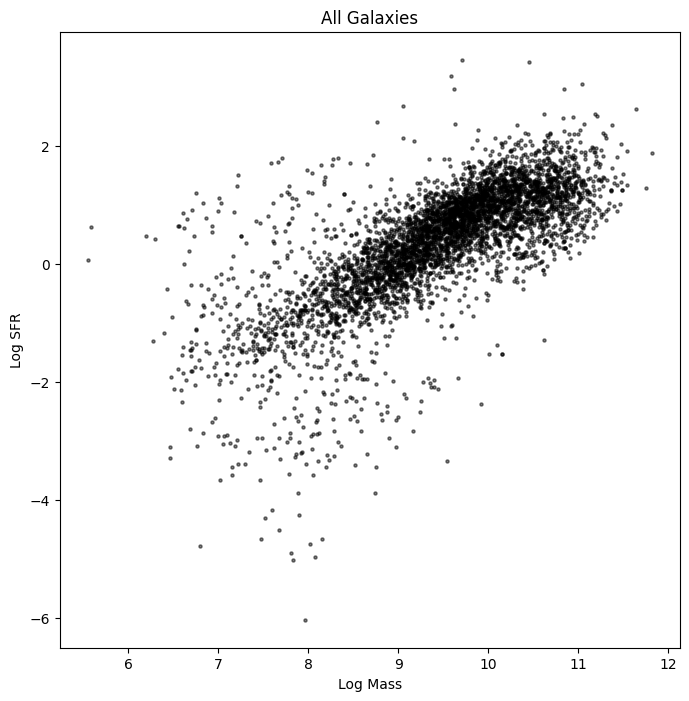

In [15]:
log_sfr_df.plot.scatter(
    x = 'mass_best',
    y = 'log_sfr',
    s = 5,
    alpha = 0.5,
    color = 'black',
    figsize = (8,8),
    xlabel = 'Log Mass',
    ylabel = 'Log SFR',
    title = 'All Galaxies'
)

### Primary vs Secondary Galaxies

In [16]:
prim_sep = (
    log_sfr_df.query('gal == "prim"')
    .rename(columns = {'id' : 'id_1_2015', 'id_2020' : 'id_1_2020', 'ez_LIR' : 'ez_LIR_1', 'ez_L2800' : 'ez_L2800_1', 'sfr_best' : 'sfr_best_1', 'photoz' : 'photoz_1',  'mass_best' : 'mass_best_1',
                      'uv_sfr': 'uv_sfr_1', 'ir_sfr': 'ir_sfr_1', 'sfr_tot': 'sfr_tot_1', 'log_sfr': 'log_sfr_1'})
    .drop(columns = 'gal')
)

sec_sep = (
    log_sfr_df.query('gal == "sec"')
    .rename(columns = {'id' : 'id_2_2015', 'id_2020' : 'id_2_2020', 'ez_LIR' : 'ez_LIR_2', 'ez_L2800' : 'ez_L2800_2', 'sfr_best' : 'sfr_best_2', 'photoz' : 'photoz_2',  'mass_best' : 'mass_best_2',
                      'uv_sfr': 'uv_sfr_2', 'ir_sfr': 'ir_sfr_2', 'sfr_tot': 'sfr_tot_2', 'log_sfr': 'log_sfr_2'})
    .drop(columns = 'gal')
)

In [17]:
sep_merge = (
    prim_sep.merge(sec_sep, on = 'SourceID', how = 'left')
)

In [18]:
sep_merge

,SourceID,id_2015_x,id_1_2020,ez_LIR_1,ez_L2800_1,sfr_best_1,photoz_1,mass_best_1,uv_sfr_1,ir_sfr_1,...,id_2_2020,ez_LIR_2,ez_L2800_2,sfr_best_2,photoz_2,mass_best_2,uv_sfr_2,ir_sfr_2,sfr_tot_2,log_sfr_2
0,4000705532455,590539,816891,1.461746e+10,6.532970e+09,0.508,0.536,9.355,2.112762,1.432511,...,812427,4.550346e+08,3.795326e+08,-1.055,0.366,7.611,0.122741,0.044593,0.167334,-0.776415
1,4000705533312,621053,873195,3.561132e+10,1.346792e+09,-0.058,0.310,10.201,0.435553,3.489909,...,872551,1.310930e+11,5.523424e+09,0.505,0.336,10.763,1.786275,12.847112,14.633387,1.165345
2,4000705533383,617834,861738,5.621026e+09,5.348111e+09,0.132,0.621,9.578,1.729579,0.550861,...,861742,2.269957e+10,2.636891e+09,1.032,0.756,9.480,0.852771,2.224557,3.077328,0.488174
3,4000705539529,882817,1284864,4.125722e+10,1.431745e+10,1.319,0.698,10.102,4.630262,4.043208,...,1281998,5.301575e+08,2.605845e+09,0.191,0.834,9.021,0.842730,0.051955,0.894686,-0.048329
4,4000705539941,893328,1301188,5.449620e+07,3.591865e+08,-1.016,0.237,8.657,0.116161,0.005341,...,1300267,1.352380e+09,3.631612e+08,-0.467,0.372,7.773,0.117446,0.132533,0.249980,-0.602095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,6000536184828,862874,1258774,1.478491e+11,1.198529e+10,1.425,0.481,10.714,3.876042,14.489211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2343,6000536185304,887383,1298440,1.230318e+11,6.801087e+09,1.216,0.538,10.940,2.199472,12.057112,...,1294806,2.763437e+09,4.709840e+09,0.580,0.480,9.326,1.523162,0.270817,1.793979,0.253817
2344,6000536185496,898134,1308675,3.568900e+10,7.501403e+09,0.670,0.868,9.918,2.425954,3.497522,...,1308556,5.335385e+08,7.185492e+07,-0.178,0.992,8.372,0.023238,0.052287,0.075525,-1.121911
2345,6000536185585,904074,1317966,6.913122e+10,1.568826e+10,1.241,0.636,9.858,5.073582,6.774860,...,1315791,1.170207e+09,7.337763e+07,-0.768,0.579,7.505,0.023730,0.114680,0.138411,-0.858831


In [19]:
sfr_dna = (
    sep_merge
    .assign(log_sfr_1_dna = sep_merge.apply(lambda row: row.log_sfr_1 if not np.isnan(row.log_sfr_1) else row.sfr_best_1, axis = 1))
    .assign(log_sfr_2_dna = sep_merge.apply(lambda row: row.log_sfr_2 if not np.isnan(row.log_sfr_2) else row.sfr_best_2, axis = 1))
)

In [20]:
sfr_dna.head()

,SourceID,id_2015_x,id_1_2020,ez_LIR_1,ez_L2800_1,sfr_best_1,photoz_1,mass_best_1,uv_sfr_1,ir_sfr_1,...,ez_L2800_2,sfr_best_2,photoz_2,mass_best_2,uv_sfr_2,ir_sfr_2,sfr_tot_2,log_sfr_2,log_sfr_1_dna,log_sfr_2_dna
0,4000705532455,590539,816891,1.461746e+10,6.532970e+09,0.508,0.536,9.355,2.112762,1.432511,...,3.795326e+08,-1.055,0.366,7.611,0.122741,0.044593,0.167334,-0.776415,0.549650,-0.776415
1,4000705533312,621053,873195,3.561132e+10,1.346792e+09,-0.058,0.310,10.201,0.435553,3.489909,...,5.523424e+09,0.505,0.336,10.763,1.786275,12.847112,14.633387,1.165345,0.593891,1.165345
2,4000705533383,617834,861738,5.621026e+09,5.348111e+09,0.132,0.621,9.578,1.729579,0.550861,...,2.636891e+09,1.032,0.756,9.480,0.852771,2.224557,3.077328,0.488174,0.358019,0.488174
3,4000705539529,882817,1284864,4.125722e+10,1.431745e+10,1.319,0.698,10.102,4.630262,4.043208,...,2.605845e+09,0.191,0.834,9.021,0.842730,0.051955,0.894686,-0.048329,0.938193,-0.048329
4,4000705539941,893328,1301188,5.449620e+07,3.591865e+08,-1.016,0.237,8.657,0.116161,0.005341,...,3.631612e+08,-0.467,0.372,7.773,0.117446,0.132533,0.249980,-0.602095,-0.915418,-0.602095


In [21]:
sfr_red = sfr_dna[['SourceID', 'mass_best_1', 'mass_best_2', 'log_sfr_1_dna', 'log_sfr_2_dna', 'sfr_best_1', 'sfr_best_2', 'photoz_1', 'photoz_2']].dropna()

#### Uncontrolled

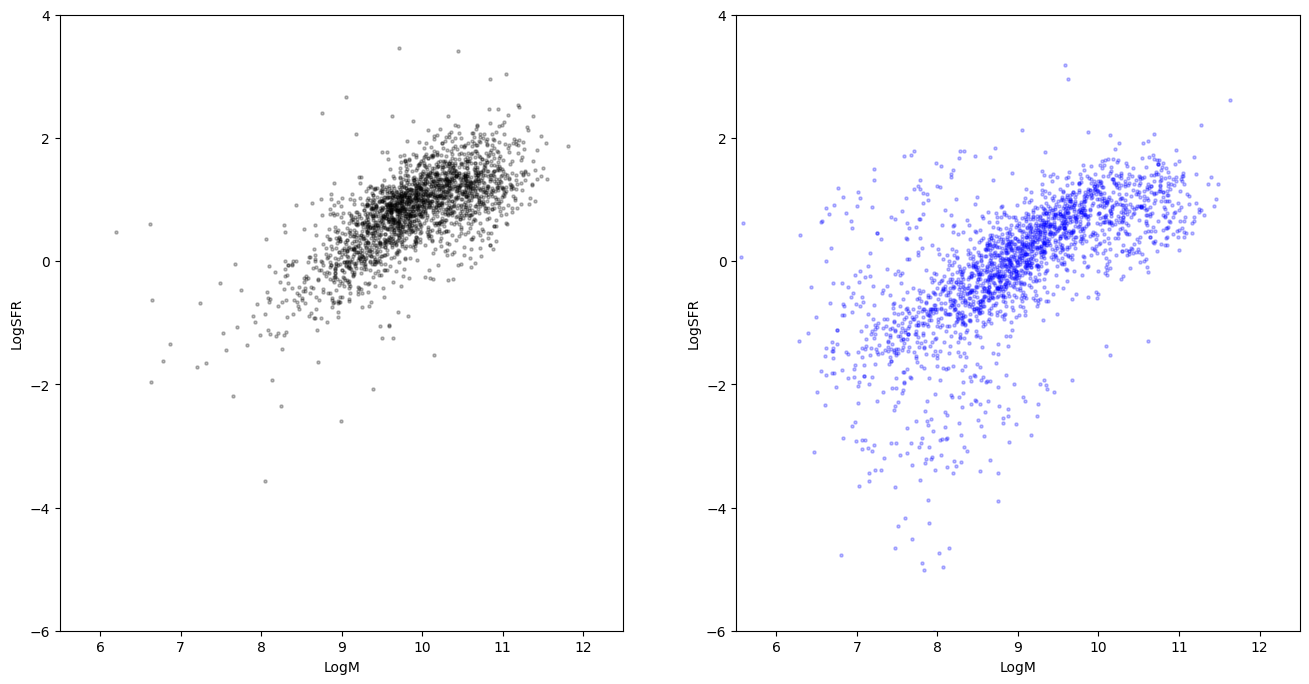

In [22]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sfr_red.plot.scatter(
    x = 'mass_best_1',
    y = 'log_sfr_1_dna',
    s = 5,
    color = 'black',
    alpha = 0.25,
    xlabel = 'LogM',
    ylabel = 'LogSFR',
    ax = ax[0],
    xlim = [5.5,12.5],
    ylim = [-6,4]
)

sfr_red.plot.scatter(
    x = 'mass_best_2',
    y = 'log_sfr_2_dna',
    s = 5,
    color = 'blue',
    alpha = 0.25,
    xlabel = 'LogM',
    ylabel = 'LogSFR',
    ax = ax[1],
    xlim = [5.5,12.5],
    ylim = [-6,4]
)
plt.show()

#### Binning by Redshift

In [23]:
def assign_bin(z, redshift_bins):
    # z < 0.25
    if z <= redshift_bins[1]:
        return 0
    # 0.25 < z < 0.5
    elif z > redshift_bins[1] and z <= redshift_bins[2]:
        return 1
    # 0.5 < z < 0.75
    elif z > redshift_bins[2] and z <= redshift_bins[3]:
        return 2
    # 0.75 z < 1
    elif z > redshift_bins[3] and z <= redshift_bins[4]:
        return 3
    else:
        return None

In [24]:
def create_plot_z(df, ax, stage):
    df.plot.scatter(
        x = 'log_mass',
        y = 'log_sfr_check',
        ax = ax,
        xlim = [5.5,12.5],
        ylim = [-6,4],
        xlabel = '',
        ylabel = '',
        title = f'{stage}',
        color = 'black',
        alpha = 0.25,
        s = 5
    )

In [25]:
redshift_bins = [0,0.25,0.5,0.75,1.0]

In [26]:
df_1 = sfr_red[['SourceID', 'mass_best_1', 'log_sfr_1_dna', 'sfr_best_1', 'photoz_1']].rename(columns = {'mass_best_1' : 'log_mass', 'log_sfr_1_dna' : 'log_sfr', 'sfr_best_1' : 'sfr_best', 'photoz_1' : 'photoz'})
df_2 = sfr_red[['SourceID', 'mass_best_2', 'log_sfr_2_dna', 'sfr_best_2', 'photoz_2']].rename(columns = {'mass_best_2' : 'log_mass', 'log_sfr_2_dna' : 'log_sfr', 'sfr_best_2' : 'sfr_best', 'photoz_2' : 'photoz'})

In [27]:
sfr_tmp = pd.concat([df_1, df_2])

In [28]:
sfr_checked = sfr_tmp.assign(log_sfr_check = sfr_tmp.apply(lambda row: row.log_sfr if not np.isnan(row.log_sfr) else row.sfr_best, axis = 1))

In [29]:
sfr_bin = sfr_checked.assign(z_bin = sfr_checked.photoz.apply(lambda x: assign_bin(x, redshift_bins)))

In [30]:
sfr_bin.head()

,SourceID,log_mass,log_sfr,sfr_best,photoz,log_sfr_check,z_bin
0,4000705532455,9.355,0.549650,0.508,0.536,0.549650,2.0
1,4000705533312,10.201,0.593891,-0.058,0.310,0.593891,1.0
2,4000705533383,9.578,0.358019,0.132,0.621,0.358019,2.0
3,4000705539529,10.102,0.938193,1.319,0.698,0.938193,2.0
4,4000705539941,8.657,-0.915418,-1.016,0.237,-0.915418,0.0


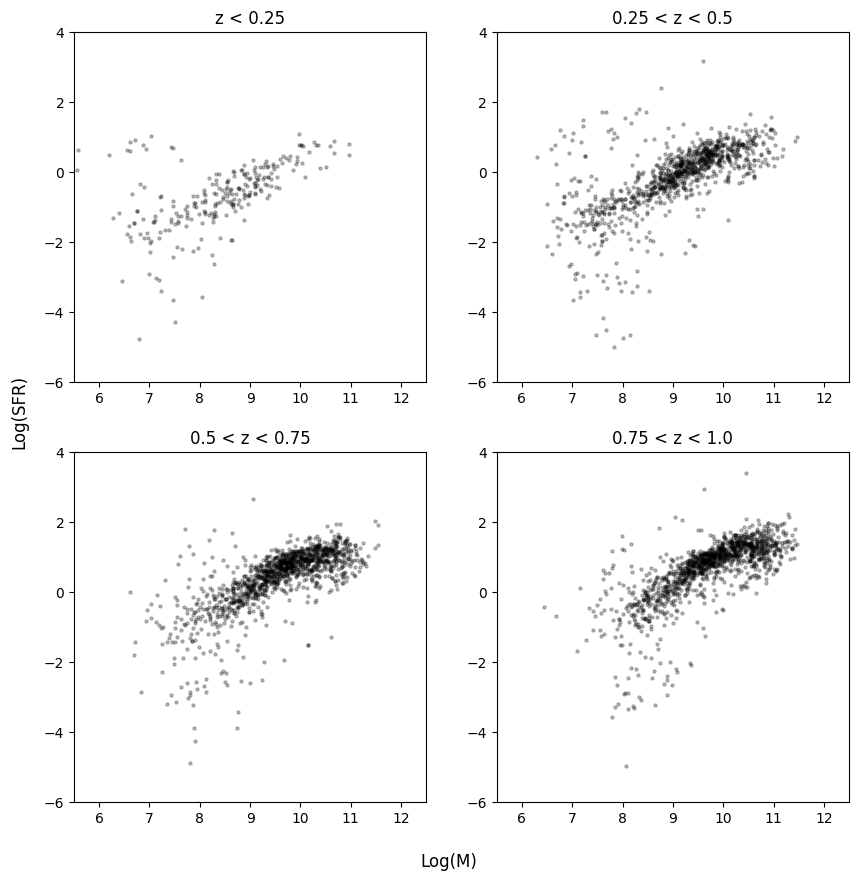

In [31]:
counter = 0
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
redshift_text = ['z < 0.25', '0.25 < z < 0.5', '0.5 < z < 0.75', '0.75 < z < 1.0']
for i in range(2):
    for j in range(2):
        create_plot_z(sfr_bin.query(f'z_bin == @counter'), axes[i,j], redshift_text[counter])
        counter += 1
fig.text(0.5, 0.05, 'Log(M)', ha='center', va='center', fontsize = 12)
fig.text(0.07, 0.5, 'Log(SFR)', ha='center', va='center', rotation='vertical', fontsize = 12)

plt.show()

#### Binning by Stage

In [32]:
cosmo_red = my_cosmo_cat[['SourceID', 'category']]

In [33]:
cat_sfr = sfr_bin.merge(cosmo_red, on = 'SourceID', how = 'left')

In [34]:
cat_sfr.head()

,SourceID,log_mass,log_sfr,sfr_best,photoz,log_sfr_check,z_bin,category
0,4000705532455,9.355,0.549650,0.508,0.536,0.549650,2.0,NaN
1,4000705533312,10.201,0.593891,-0.058,0.310,0.593891,1.0,stage3
2,4000705533383,9.578,0.358019,0.132,0.621,0.358019,2.0,stage1
3,4000705539529,10.102,0.938193,1.319,0.698,0.938193,2.0,stage1
4,4000705539941,8.657,-0.915418,-1.016,0.237,-0.915418,0.0,stage2


In [35]:
def create_plot(df, ax, stage, control):
    df.plot.scatter(
        x = 'log_mass',
        y = 'log_sfr_check',
        ax = ax,
        xlim = [5.5,12.5],
        ylim = [-6,4],
        xlabel = '',
        ylabel = '',
        title = f'{control} {stage}',
        color = 'black',
        alpha = 0.25,
        s = 5
    )

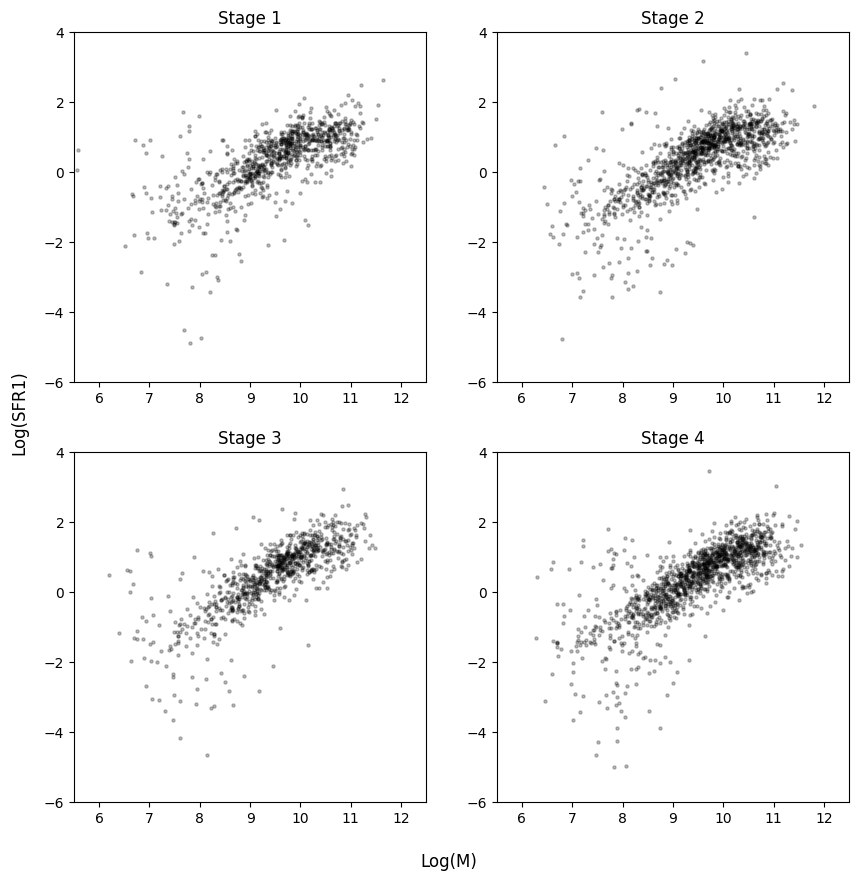

In [36]:
counter = 1
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
for i in range(2):
    for j in range(2):
        create_plot(cat_sfr.query(f'category == "stage{counter}"'), axes[i,j], counter, 'Stage')
        counter += 1
        
fig.text(0.5, 0.05, 'Log(M)', ha='center', va='center', fontsize = 12)
fig.text(0.07, 0.5, 'Log(SFR1)', ha='center', va='center', rotation='vertical', fontsize = 12)

plt.show()

### Total Mass vs Total SFR Per System

#### Uncontrolled

In [37]:
sfr_dna_red = sfr_dna[['SourceID', 'photoz_1', 'photoz_2', 'mass_best_1', 'mass_best_2', 'log_sfr_1_dna', 'log_sfr_2_dna']]

In [38]:
def adding_log(logx1, logx2):
    
    if np.isnan(logx1) or np.isnan(logx2):
        return np.nan
    
    x1 = 10**logx1
    x2 = 10**logx2
    x_tot = x1 + x2
    
    log_xtot = np.log10(x_tot)
    
    return log_xtot

In [39]:
sfr_tots = (
    sfr_dna_red
    .assign(log_sfr = sfr_dna_red.apply(lambda row: adding_log(row.log_sfr_1_dna, row.log_sfr_2_dna), axis = 1))
    .assign(log_mass = sfr_dna_red.apply(lambda row: adding_log(row.mass_best_1, row.mass_best_2), axis = 1))
    .assign(redshift = sfr_dna_red.apply(lambda row: row.photoz_1 if not np.isnan(row.photoz_1) else row.photoz_2, axis = 1))
)

In [40]:
sfr_tots_red = sfr_tots[['SourceID', 'photoz_1', 'photoz_2', 'log_sfr', 'log_mass', 'redshift']]

<AxesSubplot:xlabel='Log(M1 + M2)', ylabel='Log(SFR1 + SFR2)'>

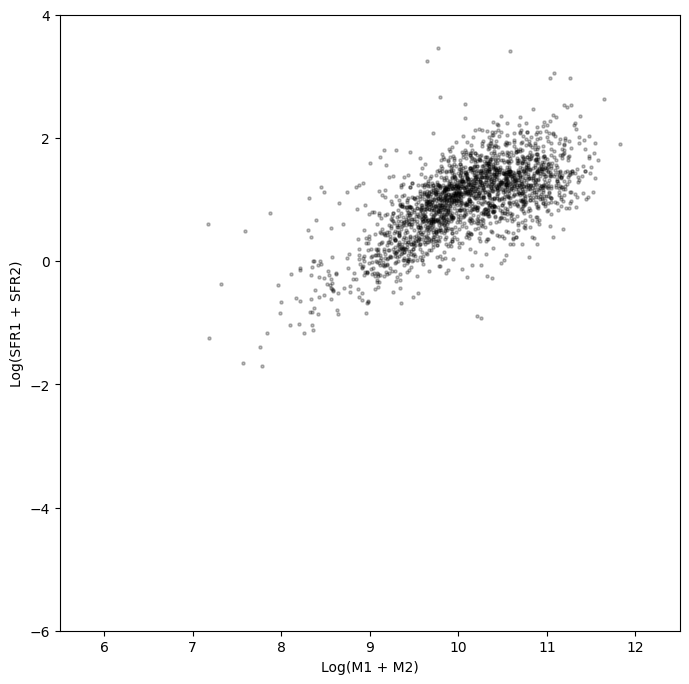

In [41]:
sfr_tots_red.plot.scatter(
    x = 'log_mass',
    y = 'log_sfr',
    s = 5,
    color = 'black',
    alpha = 0.25,
    xlabel = 'Log(M1 + M2)',
    ylabel = 'Log(SFR1 + SFR2)',
    xlim = [5.5,12.5],
    ylim = [-6,4],
    figsize = (8,8)
)

#### Binning by Redshift

In [42]:
tot_z_bin = sfr_tots_red.assign(z_bin = sfr_tots_red.redshift.apply(lambda x: assign_bin(x, redshift_bins)))[['SourceID', 'log_sfr', 'log_mass', 'redshift', 'z_bin']].dropna()

In [43]:
def create_plot_z(df, ax, stage):
    df.plot.scatter(
        x = 'log_mass',
        y = 'log_sfr',
        ax = ax,
        xlim = [5.5,12.5],
        ylim = [-6,4],
        xlabel = '',
        ylabel = '',
        title = f'{stage}',
        color = 'black',
        alpha = 0.25,
        s = 5
    )

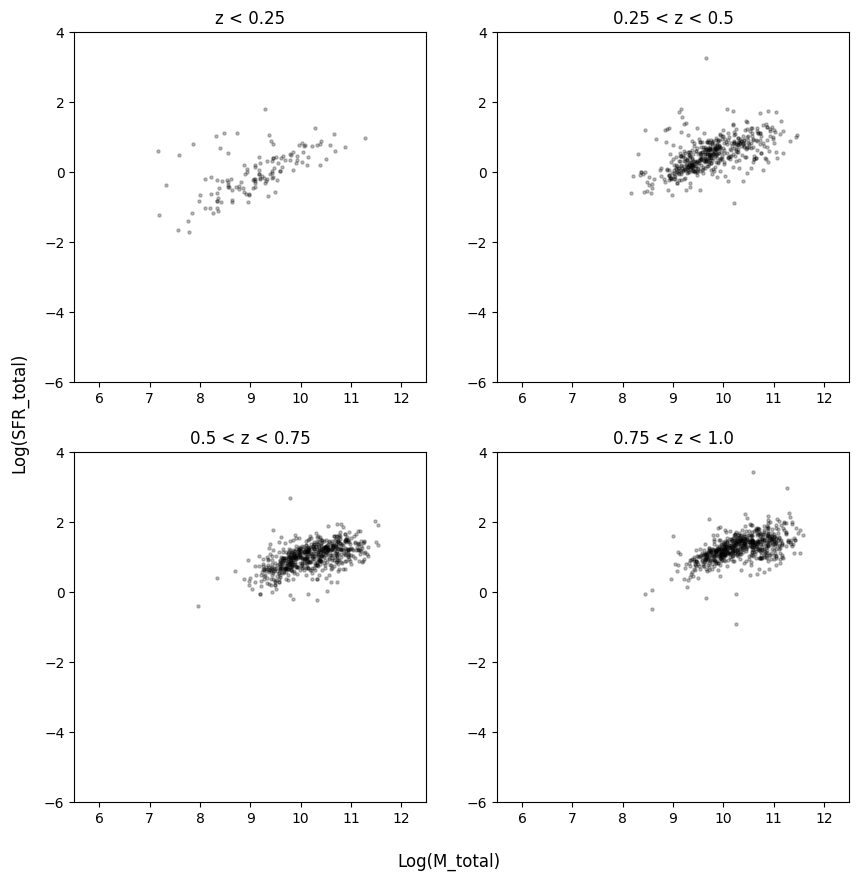

In [44]:
counter = 0
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
redshift_text = ['z < 0.25', '0.25 < z < 0.5', '0.5 < z < 0.75', '0.75 < z < 1.0']
for i in range(2):
    for j in range(2):
        create_plot_z(tot_z_bin.query(f'z_bin == @counter'), axes[i,j], redshift_text[counter])
        counter += 1
        
fig.text(0.5, 0.05, 'Log(M_total)', ha='center', va='center', fontsize = 12)
fig.text(0.07, 0.5, 'Log(SFR_total)', ha='center', va='center', rotation='vertical', fontsize = 12)

plt.show()

#### Binning by Stage

In [45]:
def create_plot(df, ax, stage, control):
    df.plot.scatter(
        x = 'log_mass',
        y = 'log_sfr',
        ax = ax,
        xlim = [5.5,12.5],
        ylim = [-6,4],
        xlabel = '',
        ylabel = '',
        title = f'{control} {stage}',
        color = 'black',
        alpha = 0.25,
        s = 5
    )

In [46]:
cat_z = tot_z_bin.merge(cosmo_red, on = 'SourceID', how = 'left')

In [47]:
cat_z

,SourceID,log_sfr,log_mass,redshift,z_bin,category
0,4000705532455,0.569679,9.362761,0.536,2.0,NaN
1,4000705533312,1.268551,10.868223,0.310,1.0,stage3
2,4000705533383,0.728984,9.832788,0.621,2.0,stage1
3,4000705539529,0.980828,10.136622,0.698,2.0,stage1
4,4000705539941,-0.430063,8.710316,0.237,0.0,stage2
...,...,...,...,...,...,...
1883,6000536184720,1.495045,10.349044,0.819,3.0,stage3
1884,6000536185304,1.205490,10.950437,0.538,2.0,stage4
1885,6000536185496,0.778079,9.930181,0.868,3.0,stage1
1886,6000536185585,1.078705,9.859922,0.636,2.0,stage3


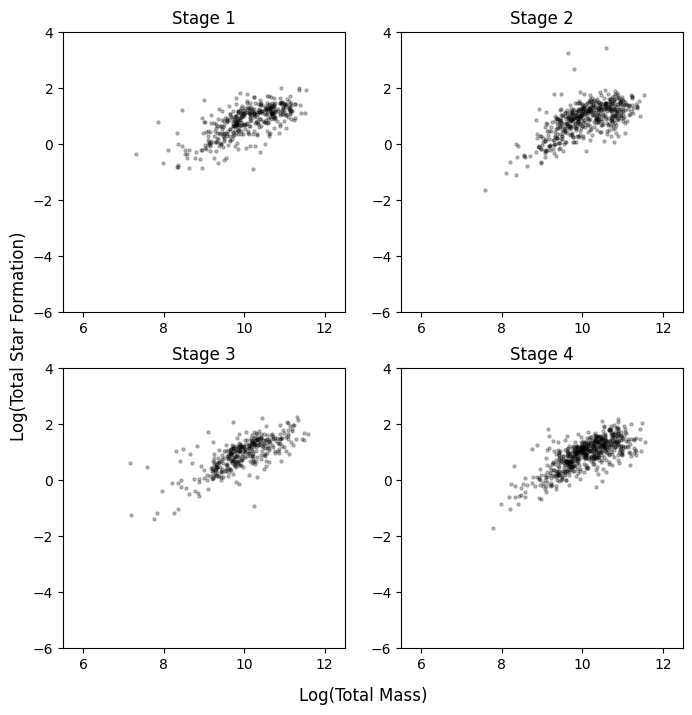

In [48]:
counter = 1
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        create_plot(cat_z.query(f'category == "stage{counter}"'), axes[i,j], counter, 'Stage')
        counter += 1
        
fig.text(0.5, 0.05, 'Log(Total Mass)', ha='center', va='center', fontsize = 12)
fig.text(0.07, 0.5, 'Log(Total Star Formation)', ha='center', va='center', rotation='vertical', fontsize = 12)

plt.show()

In [52]:
cat_z

,SourceID,log_sfr,log_mass,redshift,z_bin,category
0,4000705532455,0.569679,9.362761,0.536,2.0,NaN
1,4000705533312,1.268551,10.868223,0.310,1.0,stage3
2,4000705533383,0.728984,9.832788,0.621,2.0,stage1
3,4000705539529,0.980828,10.136622,0.698,2.0,stage1
4,4000705539941,-0.430063,8.710316,0.237,0.0,stage2
...,...,...,...,...,...,...
1883,6000536184720,1.495045,10.349044,0.819,3.0,stage3
1884,6000536185304,1.205490,10.950437,0.538,2.0,stage4
1885,6000536185496,0.778079,9.930181,0.868,3.0,stage1
1886,6000536185585,1.078705,9.859922,0.636,2.0,stage3


In [58]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, colour):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s = 0.5, color=colour)
    ax.set_xlim([5.5,12.5])
    ax.set_ylim([-6, 5])

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(12.5, 5)
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, histtype = 'step', color = colour)
    ax_histy.hist(y, bins=bins, orientation='horizontal', histtype='step', color=colour)

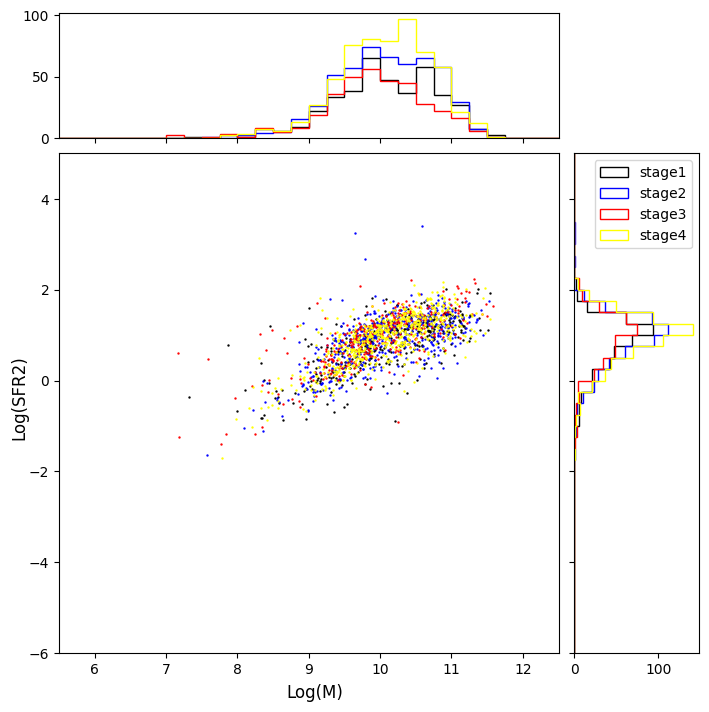

In [59]:
fig = plt.figure(figsize = (8,8))
gs = fig.add_gridspec(2,2, width_ratios = (4,1), height_ratios = (1,4), left = 0.1, right = 0.9, bottom = 0.1, top = 0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0],sharex=ax)
ax_histy = fig.add_subplot(gs[1,1],sharey=ax)

colours = ['black','blue','red','yellow']

for i in range(0,4):
    df_stage = cat_z.query(f'category == "stage{i+1}"')

    scatter_hist(np.array(list(df_stage.log_mass)), np.array(list(df_stage.log_sfr)), ax, ax_histx, ax_histy, colours[i])
    
fig.text(0.42, 0.05, 'Log(M)', ha='center', va='center', fontsize = 12)
fig.text(0.05, 0.42, 'Log(SFR2)', ha='center', va='center', rotation='vertical', fontsize = 12)

plt.legend(['stage1','stage2','stage3','stage4'])

plt.show()

### Limitation

<AxesSubplot:xlabel='Photometric Redshift', ylabel='Log Mass'>

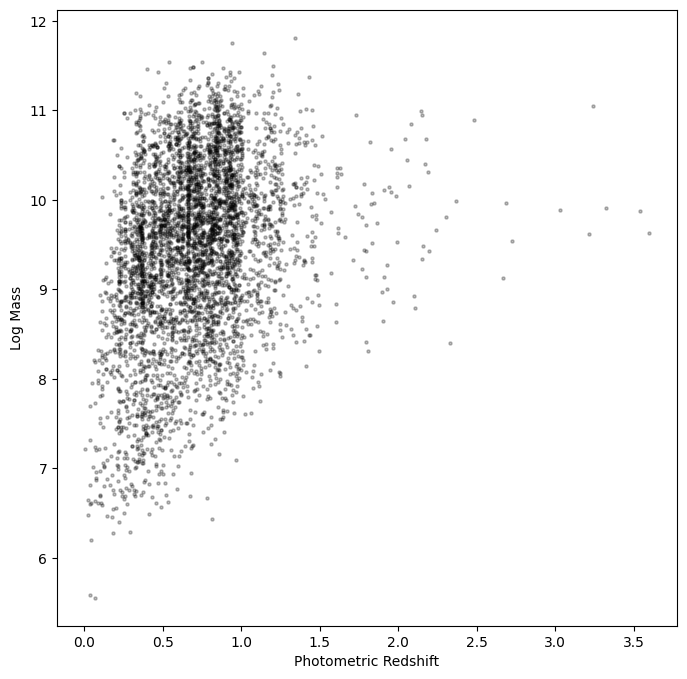

In [49]:
log_sfr_df.plot.scatter(
    x = 'photoz',
    y = 'mass_best',
    s = 5,
    color = 'black',
    alpha = 0.25,
    figsize = (8,8),
    xlabel = 'Photometric Redshift',
    ylabel = 'Log Mass'
)

### Looking at Limitation with Mass Ratio